<a href="https://colab.research.google.com/github/sa-shah/QuDPy/blob/master/QuDPy_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook contains the examples that showcase the use of QuDpy

The examples utilize a harmonic oscillator and showcase:


1.   Generation and utilization of double-sided diagrams
2.   Creation of a harmonic oscillator system
3.   Single evolution of a system
4.   2D coherence from a third order rephasing digram (R1)
5.   2D coherence from a third order non-rephasing diagram (R4)
6.   Inclusion of dephasing dynamics in 4 and 5
7.   Inclusion of relaxation dynamics in 4 and 5
8.   Inclusion of anharmonicity between energy levels and its consequences

In [1]:
# for installing QuDPy and its dependencies i.e. numpy, qutip, matplotlib and ufss
!pip install qudpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 2.9 MB/s 
     |████████████████████████████████| 14.7 MB 22.8 MB/s 
     |████████████████████████████████| 2.6 MB 38.0 MB/s 
     |████████████████████████████████| 1.7 MB 35.4 MB/s 
  Created wheel for pyx: filename=PyX-0.15-py3-none-any.whl size=434913 sha256=8a85ad7ca21c69300560231352dae3390b284785edd7a8af4a67dc48a18a1204
  Stored in directory: /root/.cache/pip/wheels/77/8f/fe/aa41325681fb75a82653adfb843b321073e572c264a5d0f8de
Successfully built pyx


In [2]:
# importing required packages
from qutip import *  # for quantum dynamics
import numpy as np  # for numerical manipulations
from qudpy.Classes import *  # for nonlinear spectroscpy
import qudpy.plot_functions as pf  # for plotting nonlinear spectra
import ufss  # for double-sided diagram generation
import os
!apt-get install texlive-fonts-recommended
!apt-get install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-texgyre
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libkpathsea6 libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2
  libzzip-0-13 lmodern poppler-data t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base tipa
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer
  texlive-fonts-recommended-doc texlive-latex-base-doc
The following NEW packages will be installed:
  f

## 1- Generating double-sided diagrams usnig UFSS package

the rephasing diagrams are R1, R2 and R3  (('Bu', 0), ('Ku', 1), ('Bd', 2)) (('Bu', 0), ('Bd', 1), ('Ku', 2)) (('Bu', 0), ('Ku', 1), ('Ku', 2))


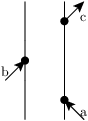

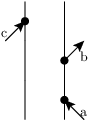

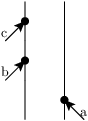

In [3]:

# Setting up the required double sided diagrams for tests
# DiagramGenerator class, or DG for short
DG = ufss.DiagramGenerator
# initialize the module
R3rd = DG()  # DG takes a single key-word argument, which has the default value detection_type = 'polarization'
# DiagramAutomation needs to know the phase-matching/-cycling condition
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])  # setting phase-matching condition for rephasing diagrams R1,2,3
# Set the pulse durations for pulses 0,1,2 and the local oscillator
d0 = 2
d1 = 4
d2 = 4
dlo = 6
# Set the pulse intervals
t0 = np.array([-d0 / 2, d0 / 2])
t1 = np.array([-d1 / 2, d1 / 2])
t2 = np.array([-d2 / 2, d2 / 2])
tlo = np.array([-dlo / 2, dlo / 2])
all_pulse_intervals = [t0, t1, t2, tlo]

# These pulse intervals are given to DG by setting DG's efield_times attribute
R3rd.efield_times = all_pulse_intervals
time_ordered_diagrams_rephasing = R3rd.get_diagrams([0, 100, 200, 200]) # selecting pulse arrival times to ensure no pulses overlap.
[R3, R1, R2] = time_ordered_diagrams_rephasing
rephasing = [R1, R2, R3]
print('the rephasing diagrams are R1, R2 and R3 ', R1, R2, R3)
R3rd.display_diagrams(rephasing)


## 2- Creation of a harmonic oscillator system

In [4]:
sys1 = System()

system initialized


With this simple command a physical system with associated operators, density matrix and Hamiltonian is initialized using Qutip.

The default values of the system are:
1. number of energy levels = n = (ground state + two excited states) = 3
2. lowering operator for 3 level-system  = $a$
3. Hamiltonian $H = \hbar \omega a^\dagger a$ with $\hbar \omega = 2 eV$ and $\hbar$ in units of eV fs. 
4. collapse operators = [ ] (system is isolated)
5. dipole = $\hat \mu = \mu (a^\dagger + a)$ with $\mu = 1$ 
6. starting density matrix in the ground state = $\rho$

These opertors uniquely define the system and its interaction with the environment. 

Therefore, these values can be externaly defined and passed to the System( ) for creating a particular configuration.

Consider the example below for a 3-level Harmonic system with E=2.3 eV, starting in the 2nd excited state

In [5]:
hbar = 0.658211951  # eV fs
E = 2.3  # eV
w = E/hbar  # frequency
a = destroy(3)
H = hbar*w*a.dag()*a
rho = fock_dm(3, 2)

sys2 = System(n=3, H=H, rho=rho, c_ops=[], a=a, u=a.dag()+a)


system initialized


## 3- Single evolution of a system

For the simple 3-level harmonic system starting in the ground state, a single evolution through a given double-sided diagram can be realized and inspected by the diagram_donkey function of the system. 


The required inputs for this function are 

1. A list of light-matter interaction times.
2. A list of double-sided diagrams
3. Time resolution for the simulation as time steps per femto-second

Outputs a plot of the expectation value for the dipole and the number of excitations for the system.

total diagrams 1 , total interactions  3


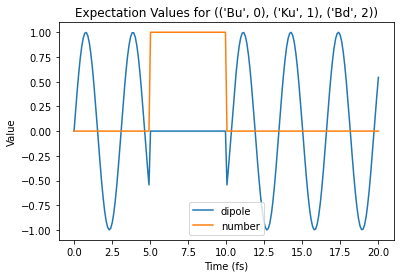

In [6]:
states = sys1.diagram_donkey([0, 5, 10, 20], [R1], r=10)

## 4- 2D coherence from a third order rephasing digram (R1)

For generating the 2D coherent signal from the system, we need to define the pulse delays between pulses and identify which delays will be scanned.

In the example below the pulses are separated by 10, 5 and 10 fs with the fist pulse arriving at t=0.

We will scan the first and last delay (both 10 fs); therefore, the scan_id list contains the indices of these delays (i.e. 0 and 2, respectively).

### Bonus: we will compute response for all rephasing diagrams (R1, R2 and R3)

In [7]:
time_delays = [10, 5, 10]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, rephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

In [8]:
spectra_list, extent, f1, f2 = sys1.spectra(response_list)

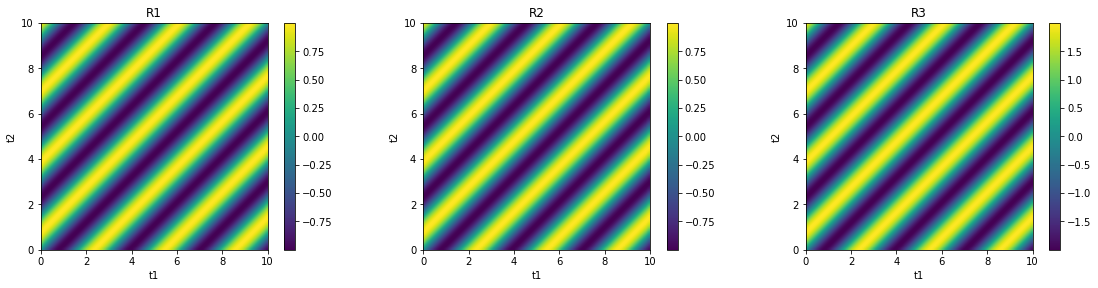

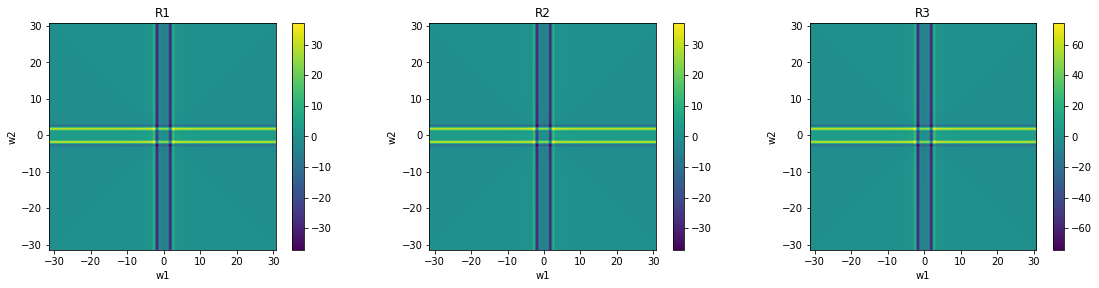

In [9]:
# Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

To make these plots more interactive, consider using "%matplotlib" in this colab notebook. If that doesnot work, consider running this example as jupyter notebook.

Or you can use your own favourite plotting library.

Note: To revert back you can use "%matplotlib inline"

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [11]:
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

## 5- 2D coherence from a third order non-rephasing diagram (R4)

First we need to calculate the non-rephasing diagrams and then the corresponding spectra.

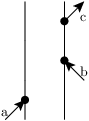

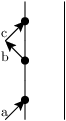

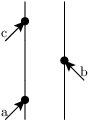

In [13]:
# Now the non-rephasing diagrams
R3rd.set_phase_discrimination([(1,0),(0,1),(1,0)])  # setting condition for nonrephasing diagrams R4, R5 and R6
time_ordered_diagrams_nonrephasing = R3rd.get_diagrams([0,100,200,200])
[R6, R4, R5] = time_ordered_diagrams_nonrephasing  # note the order is R6, R4, R5
nonrephasing = [R4, R5, R6]
R3rd.display_diagrams(nonrephasing)

In [14]:
time_delays = [10, 5, 10]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, nonrephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

In [15]:
spectra_list, extent, f1, f2 = sys1.spectra(response_list)

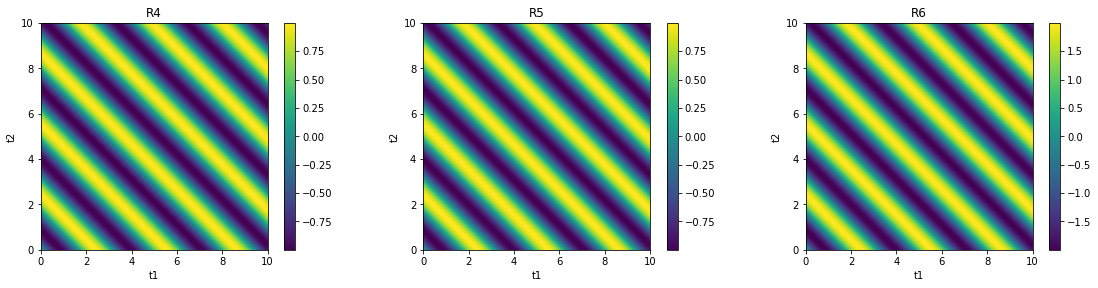

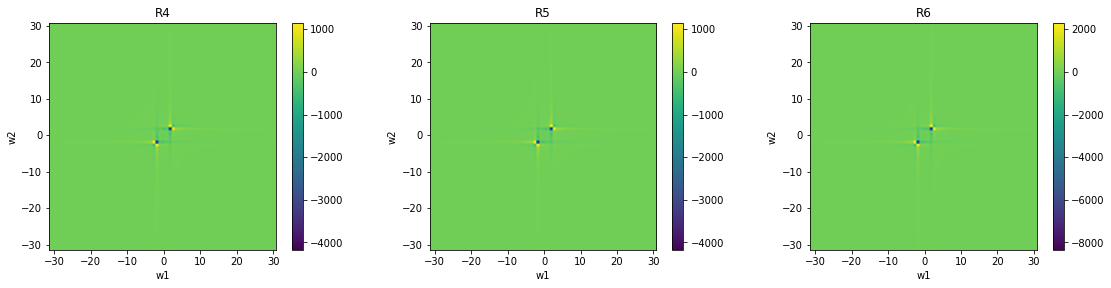

In [16]:
# Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R4', 'R5', 'R6'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R4', 'R5', 'R6'], 'linear')

## 6- Inclusion of dephasing dynamics in 4 and 5
Consider a simple system-bath interaction that leads to dephasing of the system. Such a model can appear in spin-phonon or exciton-phonon interaction. The model Hamiltonian is given by

$$
H = \hbar \omega a^\dagger a + V
$$

here $V$ is the interaction term given by 
$$
V = \gamma a^\dagger a (b + b^\dagger)
$$
where $(b+b^\dagger) \propto q$ with q as the phonon displacement

This interaction can be implemented via simple collapse operators ($C = \sqrt{\gamma} a^\dagger a $ using Qutip 

Taking $\gamma = 0.23$

In [17]:
c_op = np.sqrt(0.23)*sys1.a.dag()*sys1.a
sys1.c_ops = [c_op]

time_delays = [10, 5, 10]
scan_id = [0, 2]

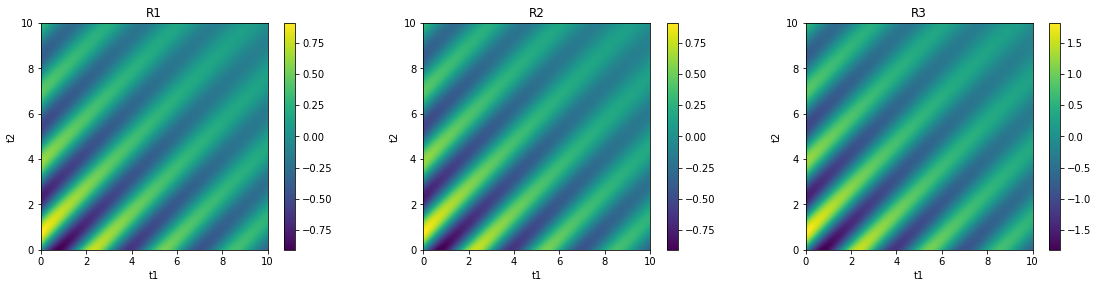

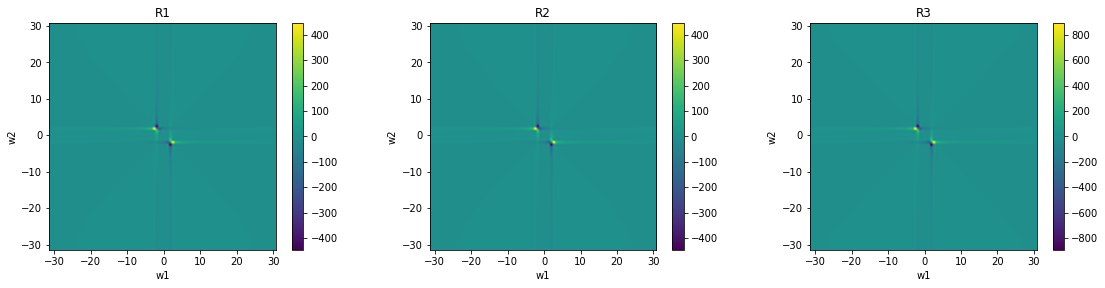

In [18]:
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, rephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys1.spectra(response_list)
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

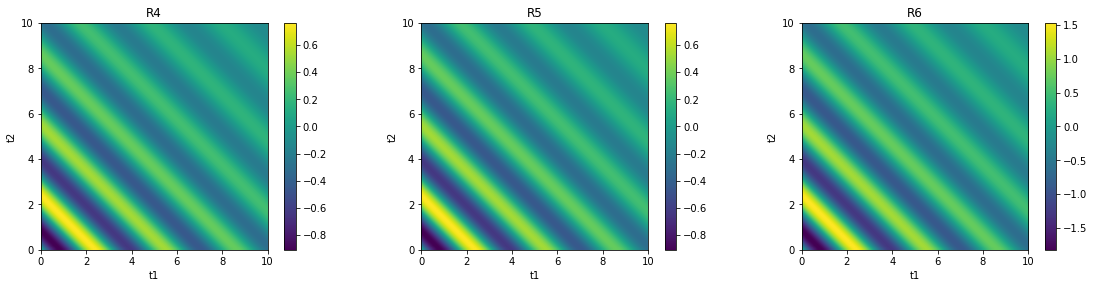

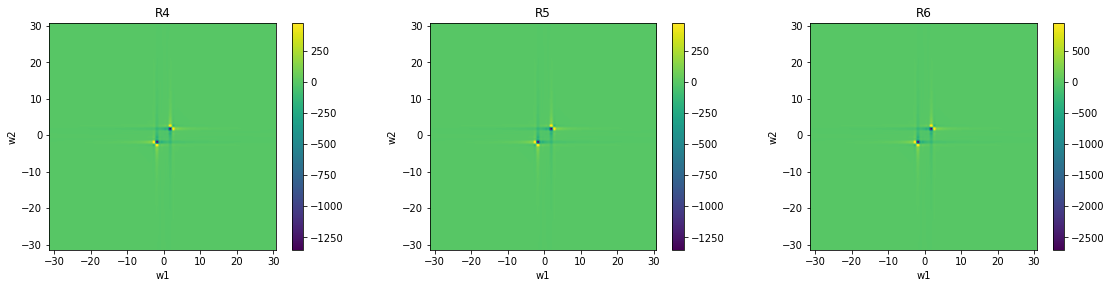

In [19]:
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, nonrephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys1.spectra(response_list)
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R4', 'R5', 'R6'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R4', 'R5', 'R6'], 'linear')

## 7- Inclusion of relaxation dynamics in 4 and 5

For including dissipation/relaxation, the following collapse operator can be utilized: $C = \sqrt{\gamma} a $ 

Taking $\gamma = 0.23$

In [20]:
c_op = np.sqrt(0.23)*sys1.a
sys1.c_ops = [c_op]

time_delays = [10, 5, 10]
scan_id = [0, 2]

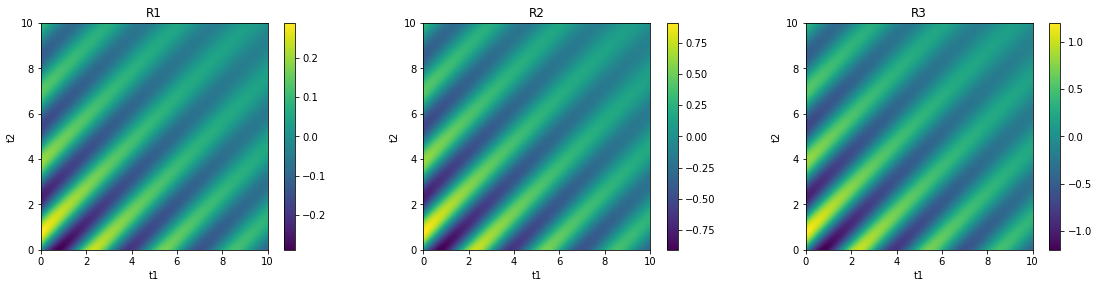

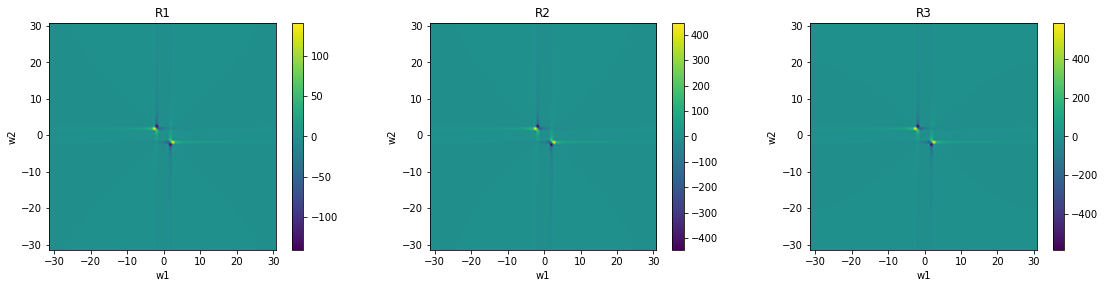

In [21]:
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, rephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys1.spectra(response_list)
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

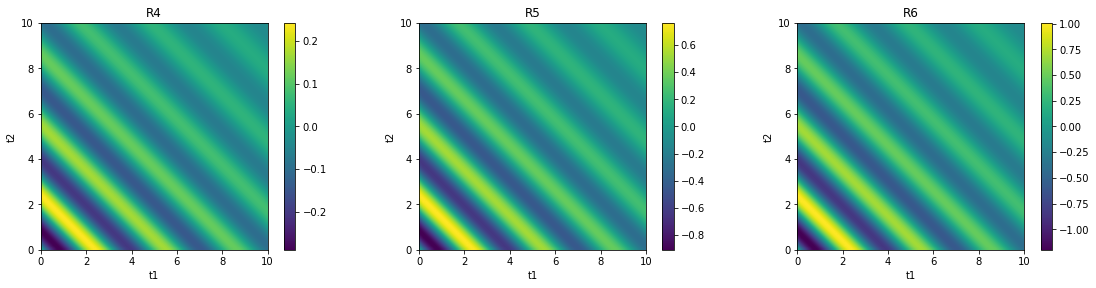

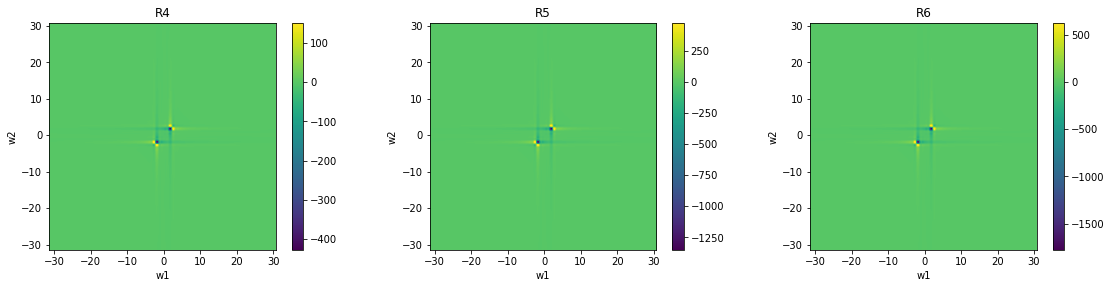

In [22]:
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, nonrephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys1.spectra(response_list)
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R4', 'R5', 'R6'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R4', 'R5', 'R6'], 'linear')

## 8- Inclusion of anharmonicity between energy levels and its consequences

The anharmonicity can be included by modifying the Hamiltonian as 

$$
H = \hbar \omega a^\dagger a + \alpha (a^\dagger a^\dagger a a )
$$

with positive $a$ indicating increasing energy gap for the excited states (consequently negative $a$ represents decreasing energy gap)

For example take $\alpha = -0.5$

In [23]:
alpha = -0.5
sys1 = System()
H = sys1.hbar*sys1.w*sys1.a.dag()*sys1.a + alpha*(sys1.a.dag()*sys1.a.dag()*sys1.a*sys1.a)
sys1.H = H

system initialized


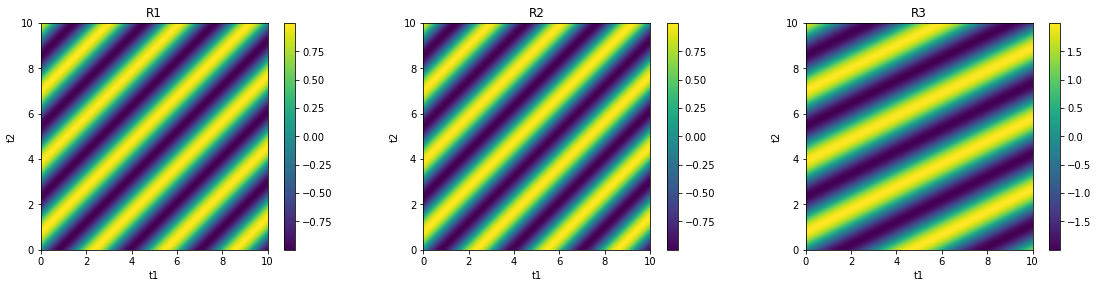

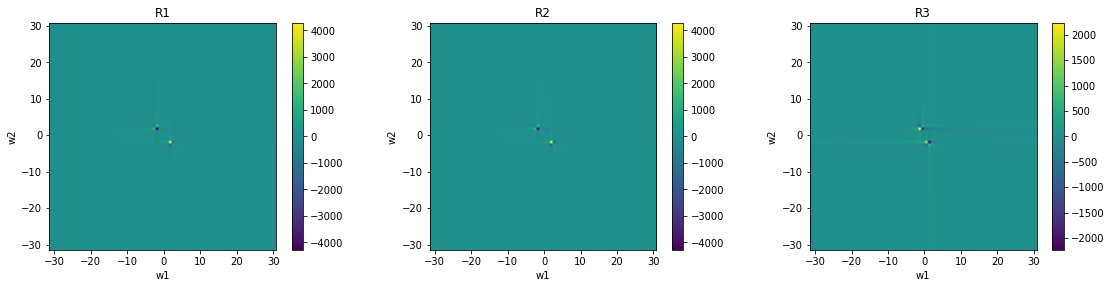

In [24]:
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys1.coherence2d(time_delays, rephasing[k], scan_id, parallel=False)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys1.spectra(response_list)
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.imag(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

In [25]:
import plotly.express as px # for plotting
import plotly.graph_objects as go # for plotting

In [26]:
img = np.real(spectra_list[2])
fig = px.imshow(img, labels=dict(x="$\omega_3$", y="$\omega_1$", color="Signal"),
                 origin='lower')
fig.show()

## creating a new system with a J aggregate idea


In [34]:
psi  = tensor(fock(2,0), fock(2,0))
rho = ket2dm(psi)
print(rho)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [35]:
print(thermal_dm(4, 2))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.41538462 0.         0.         0.        ]
 [0.         0.27692308 0.         0.        ]
 [0.         0.         0.18461538 0.        ]
 [0.         0.         0.         0.12307692]]


if there are N number of states in the system and average number of excitations are n then the thermal_dm routine implements 
$$\beta = log(\frac{1}{n}+1)$$

$$\rho_{therm} = 
\frac{1}{\sum_{i=0}^4{e^{-\beta i}}}
\begin{bmatrix}
e^{-\beta 0} & 0 & 0 & 0\\
0 & e^{-\beta 1} & 0 & 0\\
0 & 0 & e^{-\beta 2} & 0\\
0 & 0 & 0 & e^{-\beta 3}\\
\end{bmatrix}
$$

For the average excitations, n, we can use a harmonic oscialltor bath model
$$
n = \frac{1}{e^{E_n/k_B T}-1}
$$

In [1]:
1e-1

0.1

In [2]:
5*1e-1

0.5

In [3]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [ ]:
from qutip import *
import numpy as np
from qudpy.Classes import *
import qudpy.plot_functions as pf
import ufss  # diagram generation

# Generating the 3rd order double-sided diagrams for rephasing and non-rephasing response
# in impulsive regime.

DG = ufss.DiagramGenerator
R3rd = DG()
# setting condition for rephasing diagrams R1,2,3
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])
# Set the pulse interval
t_pulse = np.array([-1, 1])
R3rd.efield_times = [t_pulse]*4
# Creating diagrams for pulse arrival times 0, 100, 200 and detection time 300.
[R3, R1, R2] = R3rd.get_diagrams([0, 100, 200, 300])
rephasing = [R1, R2, R3]
print('the rephasing diagrams are R1, R2 and R3 ', rephasing)

# setting conditions for and generating non-rephasing diagrams R4, R5 and R6
R3rd.set_phase_discrimination([(1, 0), (0, 1), (1, 0)])
[R6, R4, R5] = R3rd.get_diagrams([0, 100, 200, 200])
nonrephasing = [R4, R5, R6]
print('the non-rephasing diagrams are R4, R5 and R6', nonrephasing)

# constructing the Hamiltonian
hbar = 0.658211951  # in eV fs
E1 = 2  # eV
E2 = 2.1  # eV
w1 = E1/hbar  # frequency
w2 = E2/hbar  # frequency
j = -0.3/hbar  # coupling
mu1 = 1.0  # dipole strength for subsystem A
mu2 = 1.0  # dipole strength for subsystem B
a = tensor(destroy(2), qeye(2))  # lowering operator for subsystem A
b = tensor(qeye(2), destroy(2))  # lowering operator of subsystem B
A = mu1*a + mu2*b  # total lowering operator for full system
mu = mu1*(a.dag()+a) + mu2*(b.dag()+b)  # total dipole operator
H = hbar*(w1*a.dag()*a + w2*b.dag()*b)  # basic Hamiltonian
H += hbar*j*(a.dag()*b+b.dag()*a)  # coupling between subsystems

# creating collapse operators using system-bath couplings
kappa = 0.1  # internal relaxation
kB = 8.617333262*1e-5  # Boltzmann constant eV/K
T = 300  # temperature in K
kT = T*kB
beta = 1/kT
n1 = 1/(np.exp(E1*beta)-1)  # <n1>, thermal populations of the uncoupled states
n2 = 1/(np.exp(E2*beta)-1)  # <n2>, thermal populations of the uncoupled states
c1 = np.sqrt(kappa*(n1+1))*a  # relaxation operators
c2 = np.sqrt(kappa*(n2+1))*b  # relaxation operators
c3 = np.sqrt(kappa*n1)*a.dag()  # excitation operators
c4 = np.sqrt(kappa*n2)*b.dag()  # excitation operators
c_ops = [c1, c2, c3, c4]  # collapse operator list

# setting up system
rho = tensor(fock_dm(2, 0), fock_dm(2, 0))  # ground state of Hamiltonian
sys = System(H=H, rho=rho, a=A, u=mu, c_ops=c_ops, diagonalize=True)

# generating single trial for R1
sys.diagram_donkey([0, 5, 10, 20], [R1])

# generating 2Dcoherence response for rephasing
time_delays = [200, 20, 200]
scan_id = [0, 2]
response_list = []
total_diagrams = rephasing+nonrephasing
for k in range(6):
    states, t1, t2, dipole = sys.coherence2d(time_delays, total_diagrams[k], scan_id, r=5, parallel=True)
    response_list.append(dipole)
spectra_list, extent, f1, f2 = sys.spectra(np.imag(response_list))


In [ ]:
pf.multiplot(np.imag(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3', 'R4', 'R5', 'R6'], 'linear')
